# Setup

## General

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import re
from os import chdir, getcwd, listdir, mkdir
from os.path import join
import pkg_resources
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
from scipy.linalg import norm
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
RUNNING_ON_COLAB = 'colab' in str(get_ipython())
HOME = getcwd()

In [4]:
if RUNNING_ON_COLAB == True:
    URL_FAA_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes.xlsx?raw=true"
    URL_ANAC_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-17_11-10-38.h5?raw=true"
    URL_EMBEDDING_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/embedding_layer___2021-04-17_11-10-38.h5?raw=true"
    URL_FAA_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes_labelled.xlsx?raw=true"
    URL_ANAC_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-17_10-28-55.h5?raw=true"
    URL_MODEL_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/model___2021-04-17_10-28-55___Bidirectional_GRU_Softmax.h5?raw=true"

else:
    URL_FAA_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes.xlsx?raw=true"
    URL_ANAC_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_16-04-53.h5?raw=true"
    URL_EMBEDDING_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/embedding_layer___2021-04-16_16-04-53.h5?raw=true"
    URL_FAA_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes_labelled.xlsx?raw=true"
    URL_ANAC_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_15-56-43.h5?raw=true"
    URL_MODEL_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/model___2021-04-16_15-56-43___Bidirectional_GRU_Softmax.h5?raw=true"

In [5]:
URLs = [URL_FAA_pr, URL_ANAC_pr, URL_TOKENIZER_pr, URL_EMBEDDING_pr, URL_FAA_cl, URL_ANAC_cl, URL_TOKENIZER_cl, URL_MODEL_cl]
filenames = ['FAA_pr.xlsx', 'ANAC_pr.xlsx', 'TK_pr.h5', 'EMB_pr.h5', 'FAA_cl.xlsx', 'ANAC_cl.xlsx', 'TK_cl.h5', 'MD_cl.h5']

chdir(HOME)
if 'temp' not in listdir():
    mkdir('temp')

chdir('temp')
for n in range(len(URLs)):
    r = requests.get(URLs[n])
    with open(filenames[n], 'wb') as file:
        file.write(r.content)

chdir(HOME)

In [6]:
filepath_FAA_pr = join(HOME, 'temp', filenames[0])
filepath_ANAC_pr = join(HOME, 'temp', filenames[1])
filepath_TK_pr = join(HOME, 'temp', filenames[2])
filepath_EMB_pr = join(HOME, 'temp', filenames[3])
filepath_FAA_cl = join(HOME, 'temp', filenames[4])
filepath_ANAC_cl = join(HOME, 'temp', filenames[5])
filepath_TK_cl = join(HOME, 'temp', filenames[6])
filepath_MD_cl = join(HOME, 'temp', filenames[7])

In [7]:
package_list = [pkg for pkg in pkg_resources.working_set]

if 'googletrans' not in [pkg.key for pkg in package_list]:
    ! pip install googletrans==3.1.0a0
import googletrans
    
if 'pdfplumber' not in [pkg.key for pkg in package_list]:
    ! pip install pdfplumber
import pdfplumber

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 1.0MB 5.9MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=88b657b811e92a3716624a6eaed143e916cc11fb427734d716e5180caa6ad1e9
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans
     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 5.6MB 4.9MB/s 
     |████████████████████████████████| 143kB 39.0MB/s 
     |████████████████████████████████| 1.9MB 42.9MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.27-cp37-none-any.whl size=32071 sha256=7fb9eae94363d51006ec2feedc6e7132ee617863e8f409ee94a182111f9bf18a
  Stored in directory: /root/.cache/pip/wheels/

In [25]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

## Projection

In [9]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

def sorted_keywords(words, tokenizer):
    w,f = [], []

    for word in words:
        if word in tokenizer.word_index.keys():
            w.append(word)
            f.append(tokenizer.word_counts[word])

    sorting_indices = np.array(f).argsort()
    return np.array(w)[sorting_indices]

def jaccard_mod(string1, string2, tokenizer, max_words = None):
    # with max_words != None, repetitions are ignored, only the frequency in the original dictionary is used
    # with max_words == None, repetitions are somewhat accounted for (not very thoughtfully..)
    
    cutoff = .5
    
    if max_words == None:
        tokens1 = tokenizer.texts_to_sequences(relevant_words(string1))
        tokens2 = tokenizer.texts_to_sequences(relevant_words(string2))
    else:
        tokens1 = sorted_keywords(relevant_words(string1), tokenizer)
        tokens1 = tokenizer.texts_to_sequences(tokens1[:max_words])
        tokens2 = sorted_keywords(relevant_words(string2), tokenizer)
        tokens2 = tokenizer.texts_to_sequences(tokens2[:max_words])
        
    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

In [10]:
df_FAA_pr = pd.read_excel(filepath_FAA_pr)[['title','requirement']]
df_ANAC_pr = pd.read_excel(filepath_ANAC_pr)[['title','requirement']]
translator = googletrans.Translator()

with open(filepath_TK_pr, 'rb') as file:
    tokenizer_pr = pickle.load(file)

with open(filepath_EMB_pr, 'rb') as file:
    embedding_layer = pickle.load(file)

## Classification

In [11]:
df_FAA_cl = pd.read_excel(filepath_FAA_cl)[['title','requirement','label','tag']]
df_ANAC_cl = pd.read_excel(filepath_ANAC_cl)[['title','requirement']] # + label + tag!!!
translator = googletrans.Translator()

with open(filepath_TK_cl, 'rb') as file:
    tokenizer_cl = pickle.load(file)
    
model = tf.keras.models.load_model(filepath_MD_cl)

sequence_length = 200

---   
# Projection

## Description

Objective: find requirements of similar semantic content.

---

<img src="https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/images/requirement_comparison.png?raw=1">

## Demo: find FAA requirement corresponding to given ANAC requirement

* Choose ANAC requirement randomly
* Translate requirement
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

Requirement: RBAC 121.313(c)

121.313  Equipamentos diversos 
Ninguém pode conduzir qualquer operação, a menos que o seguinte equipamento esteja instalado no avião: (c) um sistema de fornecimento e distribuição de energia elétrica que atenda aos requisitos das seções 25.1309, 25.1331, 25.1351(a) e (b)(1) até (4), 25.1353, 25.1355 e 25.1431(b) do RBAC 25, ou que seja capaz de produzir e distribuir energia para os instrumentos e equipamentos requeridos com uma fonte de força extra, se qualquer uma fonte de energia ou componente do sistema básico de distribuição de energia falhar. O uso de elementos comuns a ambos os sistemas pode ser aprovado, desde que seja considerado que eles tenham sido projetados para serem razoavelmente protegidos contra defeitos. Fontes de energia acionadas pelos motores, quando usadas, devem ser instaladas em motores diferentes; 


Translated requirement:

121,313 Miscellaneous equipment
No one may conduct any operation unless the following equipment is installed

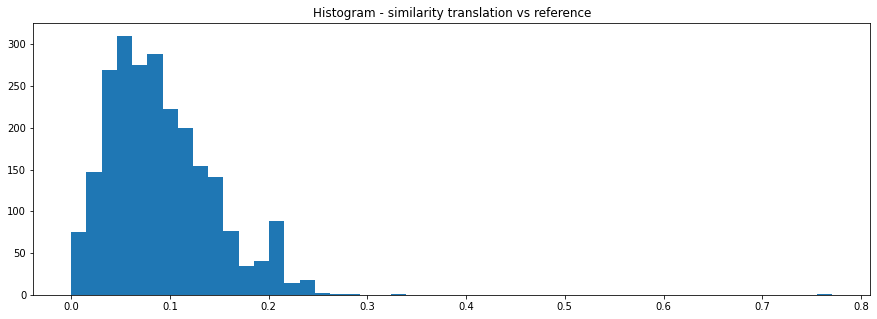

In [17]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_pr.shape[0])

req = df_ANAC_pr.requirement[EXAMPLE_NUMBER]
title = df_ANAC_pr.title[EXAMPLE_NUMBER]
print('Requirement: RBAC {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(translation, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('Match: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.round(np.max(similarity),3)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity translation vs reference')
plt.show()

## Demo: find match to user input

* Ask for requirement as input (in English)
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

-> Paste an operational requirement below:

121,375 Maintenance and preventive maintenance training program Each certificate holder, or person performing maintenance or maintenance work preventive action for the holder, should establish a training program that ensures that each person (including mandatory inspection personnel) responsible for determining the suitability of a work carried out is fully informed about procedures, techniques and new equipment in use and is competent to perform its duties.

Match: FAR § 121.375
Similarity index: 0.9032258064516129

Matching requirement text:

§ 121.375   Maintenance and preventive maintenance training program.
Each certificate holder or person performing maintenance or preventive maintenance functions for it shall have a training program to ensure that each person (including inspection personnel) who determines the adequacy of work done is fully informed about procedures and techniques and new equipment in use and is competent to perform hi

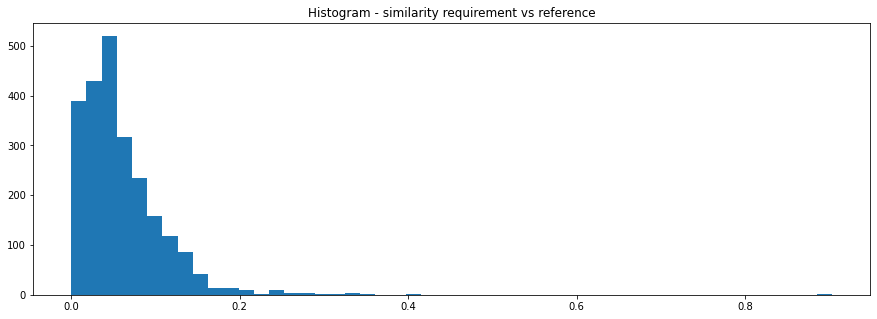

In [13]:
req = input('-> Paste an operational requirement below:\n\n')

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(req, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('\nMatch: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.round(np.max(similarity), 3)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity requirement vs reference')
plt.show()

---   
# Classification

## Description

Objective: read requirement and classify in either "Title Only", "Aircraft" or "Operator"   

-----   

<img src="https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/images/requirement_classification.png?raw=1">

## Demo: classify random FAA requirement

* Select FAA part 121 requirement randomly
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [14]:
EXAMPLE_NUMBER = np.random.randint(0,df_FAA_cl.shape[0])

req = df_FAA_cl.requirement[EXAMPLE_NUMBER]
title = df_FAA_cl.title[EXAMPLE_NUMBER]
correct_tag = df_FAA_cl.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

tokens = tokenizer_cl.texts_to_sequences([req])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = tf.constant(np.array(padded_tokens))
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
print('\nCorrect label: {}'.format(correct_tag))

Requirement: § 121.687(a)(5)

§ 121.687   Dispatch release: Flag and domestic operations.
(a) The dispatch release may be in any form but must contain at least the following information concerning each flight: 
(5) Minimum fuel supply. 

Predicted label: Operator
Level of Confidence: 99.962%

Correct label: Operator


## Demo: classify random ANAC requirement

* Select ANAC RBAC 121 requirement randomly
* Translate to English
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [15]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_cl.shape[0])

req = df_ANAC_cl.requirement[EXAMPLE_NUMBER]
title = df_ANAC_cl.title[EXAMPLE_NUMBER]
#correct_tag = df_ANAC.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

tokens = tokenizer_cl.texts_to_sequences([translation])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
#print('\nCorrect label: {}'.format(correct_tag))

Requirement: 121.310(f)(2)

121.310  Equipamento adicional de emergência 
(f) Acesso às saídas de emergência. Cada avião transportando passageiros deve prover acesso às saídas de emergência de acordo com o seguinte: (2) deve haver suficiente espaço próximo às saídas Tipo I e Tipo II, que estejam incluídas no parágrafo (a) desta seção, para permitir que um tripulante ajude na evacuação de passageiros sem reduzir a largura desobstruída de passagem requerida pelo parágrafo (f) (1) desta seção. Entretanto, a ANAC pode autorizar desvios deste requisito para um avião de tipo certificado segundo as provisões da parte 4b do “Civil Air Regulations”, dos Estados Unidos da América, em efeito antes de 20 de dezembro de 1951, se for considerado que existem circunstâncias especiais provendo um nível de segurança equivalente; 


Translated requirement:

121,310 Additional emergency equipment
(f) Access to emergency exits. Each airplane carrying passengers must provide access to the emergency exits in

## Demo: classify user input

* Ask for requirement as input (in English)
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [16]:
REQUIREMENT = input('-> Paste an operational requirement below:\n\n')

tokens = tokenizer_cl.texts_to_sequences([REQUIREMENT])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('\nPredicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))

-> Paste an operational requirement below:

121,375 Maintenance and preventive maintenance training program Each certificate holder, or person performing maintenance or maintenance work preventive action for the holder, should establish a training program that ensures that each person (including mandatory inspection personnel) responsible for determining the suitability of a work carried out is fully informed about procedures, techniques and new equipment in use and is competent to perform its duties.

Predicted label: Operator
Level of Confidence: 99.876%
